# Adaptive Sampling
[Back to the Introduction](./00_BESOS_SurrogateModelling.ipynb)

This notebook aims to reduce the number of samples required to train an accurate surrogate model. One approach is to use adaptive sampling, which explores the design space in under-sampled parts of the design space while exploiting the knowledge gained from already finished simulation runs (exploration). 

This notebook is an example of the use of Lola-Voronoi based sampling. It is applicable in connection with any surrogate model type. Here it is applied with a Gaussian Process model. [[1]]

[1]: https://ieeexplore.ieee.org/abstract/document/5429687/

<img src="LOLA-Voronoi.jpg">

In [1]:
from besos import eppy_funcs as ef
import sampling
import numpy as np
import pandas as pd

from problem import EPProblem
from evaluator import EvaluatorEP

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sampling import adaptive_sampler_lv
from parameter_sets import parameter_set

## Define sampler settings

In [2]:
n_samples_init = 30 # initial set of samples collected using common low-discrepancy sampling

no_iter = 5 # number of iterations the sampler runs
n = 4 # number of samples added per iteration of the adaptive sampler

## Set up parameters, objectives to set up a problem and an E+ evaluator instance.

For more details on that part check out other notebooks in the Example folder.

In [3]:
parameters = parameter_set(7)
problem = EPProblem(parameters, ['Electricity:Facility'])
building = ef.get_building()
inputs = sampling.dist_sampler(sampling.lhs, problem, n_samples_init)
evaluator = EvaluatorEP(problem, building, multi = False)
outputs = evaluator.df_apply(inputs)

C:\Users\mr.pww\PycharmProjects\besos\besos\problem.py:77: RuntimeWarning: Duplicate names found. (duplicate, repetitions): [('Watts per Zone Floor Area', 2)]
Attempting to fix automatically
  warnings.warn(RuntimeWarning(f'Duplicate names found. (duplicate, repetitions): '


## Initial training of Surrogate Model
Here we use a Gaussian Process surrogate model. Feel free to check out the $\textit{Fit GP model}$ notebook for more details.

In [4]:
train_in, test_in, train_out, test_out = train_test_split(inputs, outputs, test_size=0.5)

In [5]:
hyperparameters = {'kernel':[None,1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
                             1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
                             #ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
                             1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),]}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, iid=True, cv=folds)
clf.fit(train_in, train_out)

print(f'The best performing model $R^2$ score on the validation set: {clf.best_score_}')
print(f'The model $R^2$ parameters: {clf.best_params_}')
print(f'The best performing model $R^2$ score on a separate test set: {clf.best_estimator_.score(test_in, test_out)}')
reg = clf.best_estimator_

The best performing model $R^2$ score on the validation set: -0.1726121001123979
The model $R^2$ parameters: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
The best performing model $R^2$ score on a separate test set: 0.5982886762120094


# LOLA - Voronoi sampling
Here we run our implementation of LOLA-Voronoi sampling. New building designs to be simulated are picked around already simulated building design with a high hybrid score $H$.

$H = V + E$ 

$H$ is used to incentives exploration $V$ and exploitation $E$. $V$ is the Voronoi cell size to approximate the sample density and $E$ the local-linear estimate to approximate the gradient in the neighbourhood of a sample.

In [6]:
AS = adaptive_sampler_lv(train_in.values, train_out.values, n, problem, evaluator, reg, test_in, test_out, verbose = False)
AS.run(no_iter)

0
1
2
3
4


In [7]:
AS.score

array([0.59828868, 0.63634656, 0.97922408, 0.98180887, 0.98532926,
       0.98715838])

## Visualization
We visualize the working scheme of the adaptive sampler by reducing the input dimensionality to 2 using multi-dimensional scaling. 

Text(0.5, 0, 'No. of samples')

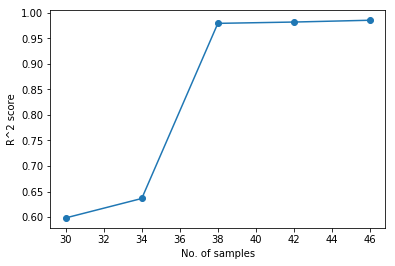

In [8]:
plt.plot(range(n_samples_init, n_samples_init + no_iter*n,n), AS.score[:-1],'-o')
plt.ylabel('R^2 score')
plt.xlabel('No. of samples')

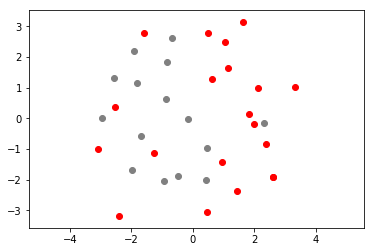

In [9]:
# Manifold model
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

scaler_mds = StandardScaler()
p_norm = scaler_mds.fit_transform(AS.P)

model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(p_norm)


plt.scatter(out3[:len(train_in), 0], out3[:len(train_in), 1], color='grey')
plt.scatter(out3[len(train_in):, 0], out3[len(train_in):, 1], color='r')
plt.axis('equal');

The density plot shows where the density of samples is high. Those areas may indicate more complex parts in the design space.

(-4, 4)

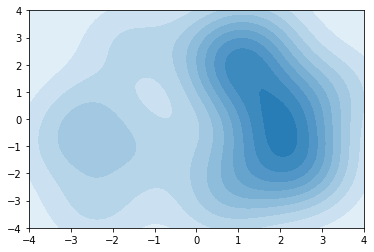

In [10]:
import seaborn as sns
ax = sns.kdeplot(out3[len(train_in):,0], out3[len(train_in):,1], shade=True)
plt.ylim([-4,4])
plt.xlim([-4,4])

C:\Users\mr.pww\Anaconda3\Lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
C:\Users\mr.pww\Anaconda3\Lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


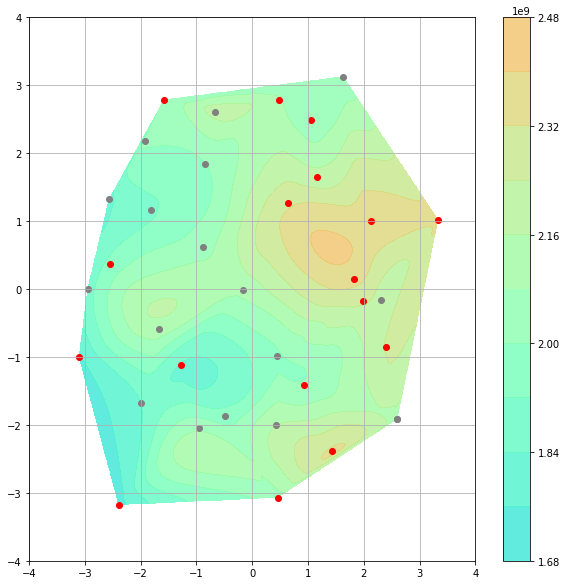

In [11]:
from scipy.interpolate import griddata
x = out3[:,0] 
y = out3[:,1]
z = reg.predict(AS.P)

# Convert from pandas dataframes to numpy arrays
X, Y, Z, = np.array([]), np.array([]), np.array([])
for i in range(len(x)):
        X = np.append(X, x[i])
        Y = np.append(Y, y[i])
        Z = np.append(Z, z[i])

# create x-y points to be used in heatmap
xi = np.linspace(X.min(), X.max(), 1000)
yi = np.linspace(Y.min(), Y.max(), 1000)

# Z is a matrix of x-y values
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

# I control the range of my colorbar by removing data 
# outside of my range of interest
zmin = 1.0*10**9
zmax = 3*10**9
zi[(zi<zmin) | (zi>zmax)] = None

# Create the contour plot
plt.figure(figsize=(10,10))
CS = plt.contourf(xi, yi, zi, 10, cmap=plt.cm.rainbow,
                  vmax=zmax, vmin=zmin, alpha=.8)
plt.colorbar()
plt.scatter(out3[:18, 0], out3[:18, 1], color='grey')
plt.scatter(out3[18:, 0], out3[18:, 1], color='r')
#ax = sns.kdeplot(out3[18:,0], out3[18:,1], shade=True)


plt.ylim([-4,4])
plt.xlim([-4,4])
plt.grid()